In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

Working on new docking oracles.

In [2]:
from dgym.envs.oracle import DockingOracle, NeuralOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'center_x': 44.294,
    'center_y': 28.123,
    'center_z': 2.617,
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'search_mode': 'fast',
    'scoring': 'gnina',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'ADAM17 affinity',
    receptor_path=f'../../dgym-data/ADAM17.pdbqt',
    config=config
)

# neural_oracle = NeuralOracle(
#     'Mpro affinity',
#     state_dict_path='../../dgym-data/neural/asapdiscovery-SARS-CoV-2-Mpro-GAT-2023.08.25.th'
# )

# create evaluators
docking_utility = ClassicUtilityFunction(
    docking_oracle,
    ideal=(8.5, 10_000),
    acceptable=(6, 10_000)
)

Create selection loop.

In [3]:
from tqdm.notebook import tqdm

class Experiment:
    
    def __init__(self, drug_agent, drug_env):
        
        self.drug_agent = drug_agent
        self.drug_env = drug_env
    
    def run(self, num_trials, progress=False):
        
        results = []
        for trial in tqdm(range(num_trials)):

            observations, info = drug_env.reset()

            if progress:
                pbar = tqdm(total = drug_env.budget)
            
            while True:
                action = drug_agent.act(observations)
                observations, _, terminated, truncated, _ = drug_env.step(action)
                try:
                    print(np.nanmax(observations.annotations['ADAM17 affinity']))
                except:
                    pass
                
                if progress:
                    pbar.n = len(drug_env.library)
                    pbar.update()
                
                if terminated or truncated:
                    break

            result = {
                'trial': trial,
                **vars(drug_agent)
            }

            if terminated:
                cost = len(drug_env.library)
                result.update({'cost': cost, 'outcome': 1})

            if truncated:
                result.update({'outcome': 0})

            results.append(result)

        return results

Run experiment.

In [4]:
import numpy as np
scores = docking_utility.oracle(deck)
best = np.argsort(scores)[-400:-300]
best_molecules = [d for d in deck[best] if len(d.reactants) == 2]

In [5]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

designer = Designer(
    Generator(building_blocks, fingerprints),
    reactions,
    cache = True
)

drug_env = DrugEnv(
    designer,
    library = dg.collection.MoleculeCollection([best_molecules[-80]]).update_annotations(),
    assays = [docking_utility.oracle],
    budget = 1_000,
    utility_function = docking_utility,
)

sequence = [
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 40, 'strict': False}},
    {'name': 'ADAM17 affinity'},
    {'name': 'ideate', 'parameters': {'temperature': 0.0, 'size': 40, 'strict': True}},
    {'name': 'ADAM17 affinity'},
]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    utility_function = docking_utility,
    exploration_strategy = EpsilonGreedy(epsilon = 0.0),
    branch_factor = 2
)

experiment = Experiment(drug_agent, drug_env)
result = experiment.run(1, progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[0]
[27, 17]
6.4737393787155
[27, 17]
6.4737393787155
[76, 98]
7.323290287106017
[76, 98]
7.323290287106017
[134, 119]
7.570368354496586
[134, 119]
7.570368354496586
[216, 220]
7.961052489564943
[216, 220]
7.961052489564943
[221, 241]
8.354965556977985
[221, 241]
8.354965556977985
[327, 322]
8.842112442385558


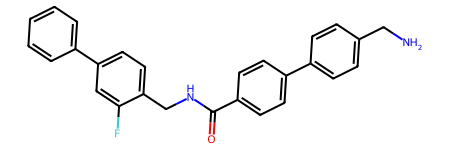

In [14]:
drug_env.library[-6]

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 16.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


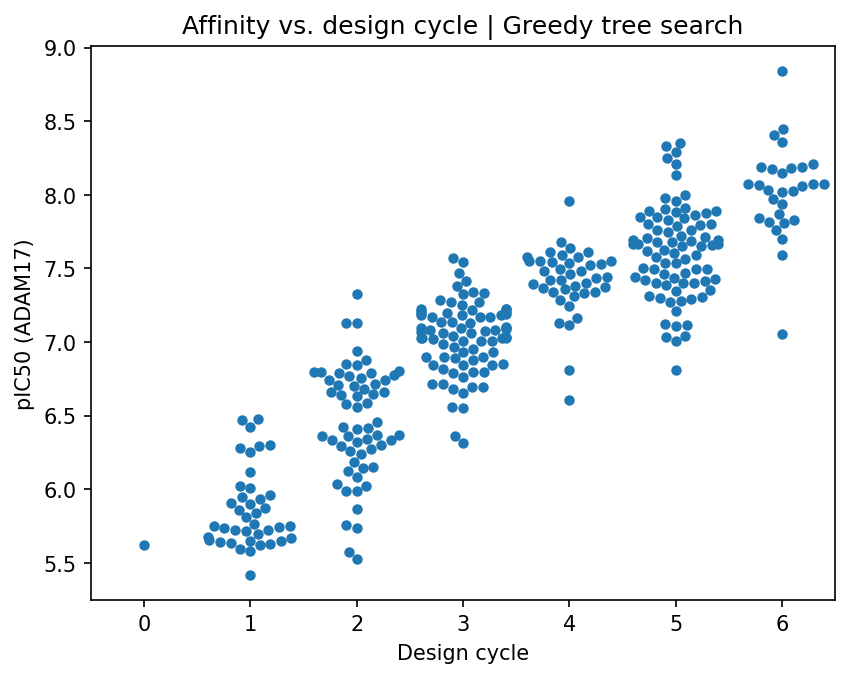

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

annotated_molecules = drug_env.library
g = sns.swarmplot(
    x = [a.design_cycle for a in annotated_molecules],
    y = docking_utility.oracle(annotated_molecules),
)

g.set_title('Affinity vs. design cycle | Greedy tree search')
g.set_xlabel('Design cycle')
g.set_ylabel('pIC50 (ADAM17)')

plt.gcf().set_dpi(150)
plt.show()

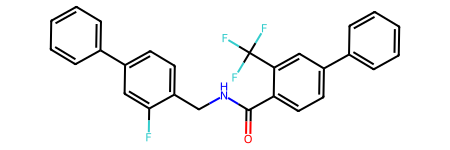

In [17]:
drug_env.library[327]

In [18]:
designer.cache = False
designer.design(annotated_molecules[-1], 10, replace_index=0)

OrderedSet({<dgym.molecule.Molecule object at 0x7fb7fff62210>, <dgym.molecule.Molecule object at 0x7fb804102350>, <dgym.molecule.Molecule object at 0x7fb7fff58290>, <dgym.molecule.Molecule object at 0x7fb7fff61d90>, <dgym.molecule.Molecule object at 0x7fb7fff61510>, <dgym.molecule.Molecule object at 0x7fb7fff5b490>, <dgym.molecule.Molecule object at 0x7fb7fff62150>, <dgym.molecule.Molecule object at 0x7fb7fff5ac10>, <dgym.molecule.Molecule object at 0x7fb7fff58e90>, <dgym.molecule.Molecule object at 0x7fb7fff58090>})

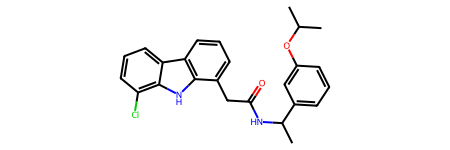

In [249]:
annotated_molecules[-3]

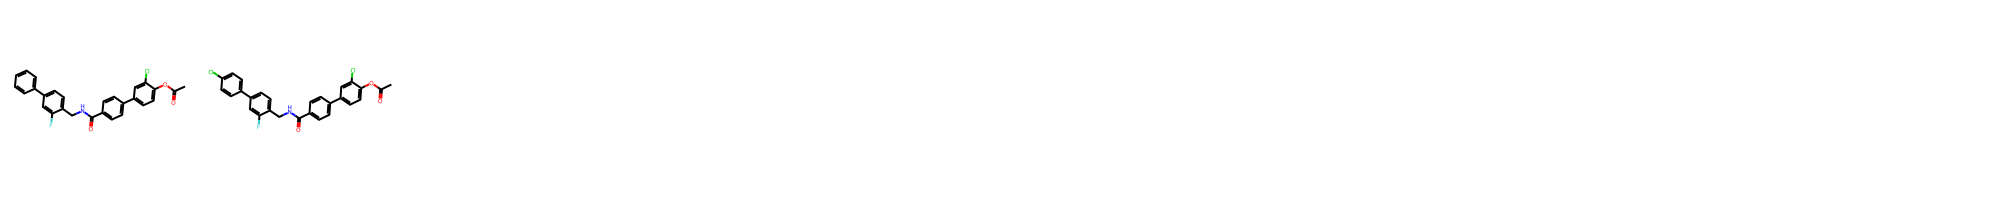

In [33]:
designer.cache = False
prods = designer.design(annotated_molecules[-1], 10, strict=True)

from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage([p.mol for p in prods], molsPerRow=10)

In [105]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from rdkit.Chem import Draw
import networkx as nx
import io

o = Draw.DrawingOptions()
o.bgColor=None

def generate_molecule_tree(molecules):
    """
    Generates a tree of molecules visualized based on their '.inspiration' attribute.

    Parameters:
    molecules (list): A list of RDKit molecule objects with an '.inspiration' attribute.
    
    Returns:
    plt.Figure: A matplotlib figure object with the rendered tree.
    """

    # Create a graph
    G = nx.DiGraph()
    for mol in molecules:
        G.add_node(mol, image=Draw.MolToImage(mol.mol))
        while mol.inspiration:
            G.add_edge(mol.inspiration, mol)
            mol = mol.inspiration
            G.add_node(mol, image=Draw.MolToImage(mol.mol))

    # Define graph layout
    pos = hierarchy_pos(G)

    # Create a matplotlib figure
    fig, ax = plt.subplots(figsize=(12, 8), dpi=500)

    # Draw the graph (without node labels or images)
    nx.draw(G, pos, ax=ax, with_labels=False, node_size=50, arrows=True)
    
    # Transform from data coordinates (scaled between xlim and ylim) to display coordinates
    tr_figure = ax.transData.transform
    # Transform from display to figure coordinates
    tr_axes = fig.transFigure.inverted().transform

    # Select the size of the image (relative to the X axis)
    icon_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.025
    icon_center = icon_size / 2.0

    # Add the respective image to each node
    for n in G.nodes:
        xf, yf = tr_figure(pos[n])
        xa, ya = tr_axes((xf, yf))
        # get overlapped axes and plot icon
        a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])
        a.imshow(G.nodes[n]["image"])
        a.axis("off")


#     # Function to convert RDKit images to array for matplotlib
#     def mol_to_array(mol):
#         img = Draw.MolToImage(mol)
#         img_byte_arr = io.BytesIO()
#         img.save(img_byte_arr, format='PNG')
#         img_byte_arr = img_byte_arr.getvalue()
#         return plt.imread(io.BytesIO(img_byte_arr))

#     # Add images to the graph
#     for node in G.nodes:
#         image = mol_to_array(node.mol)
#         imagebox = OffsetImage(image, zoom=0.2)  # Adjust zoom as needed
#         ab = AnnotationBbox(imagebox, pos[node], frameon=False, pad=0.1)
#         ax.add_artist(ab)

    return fig, G

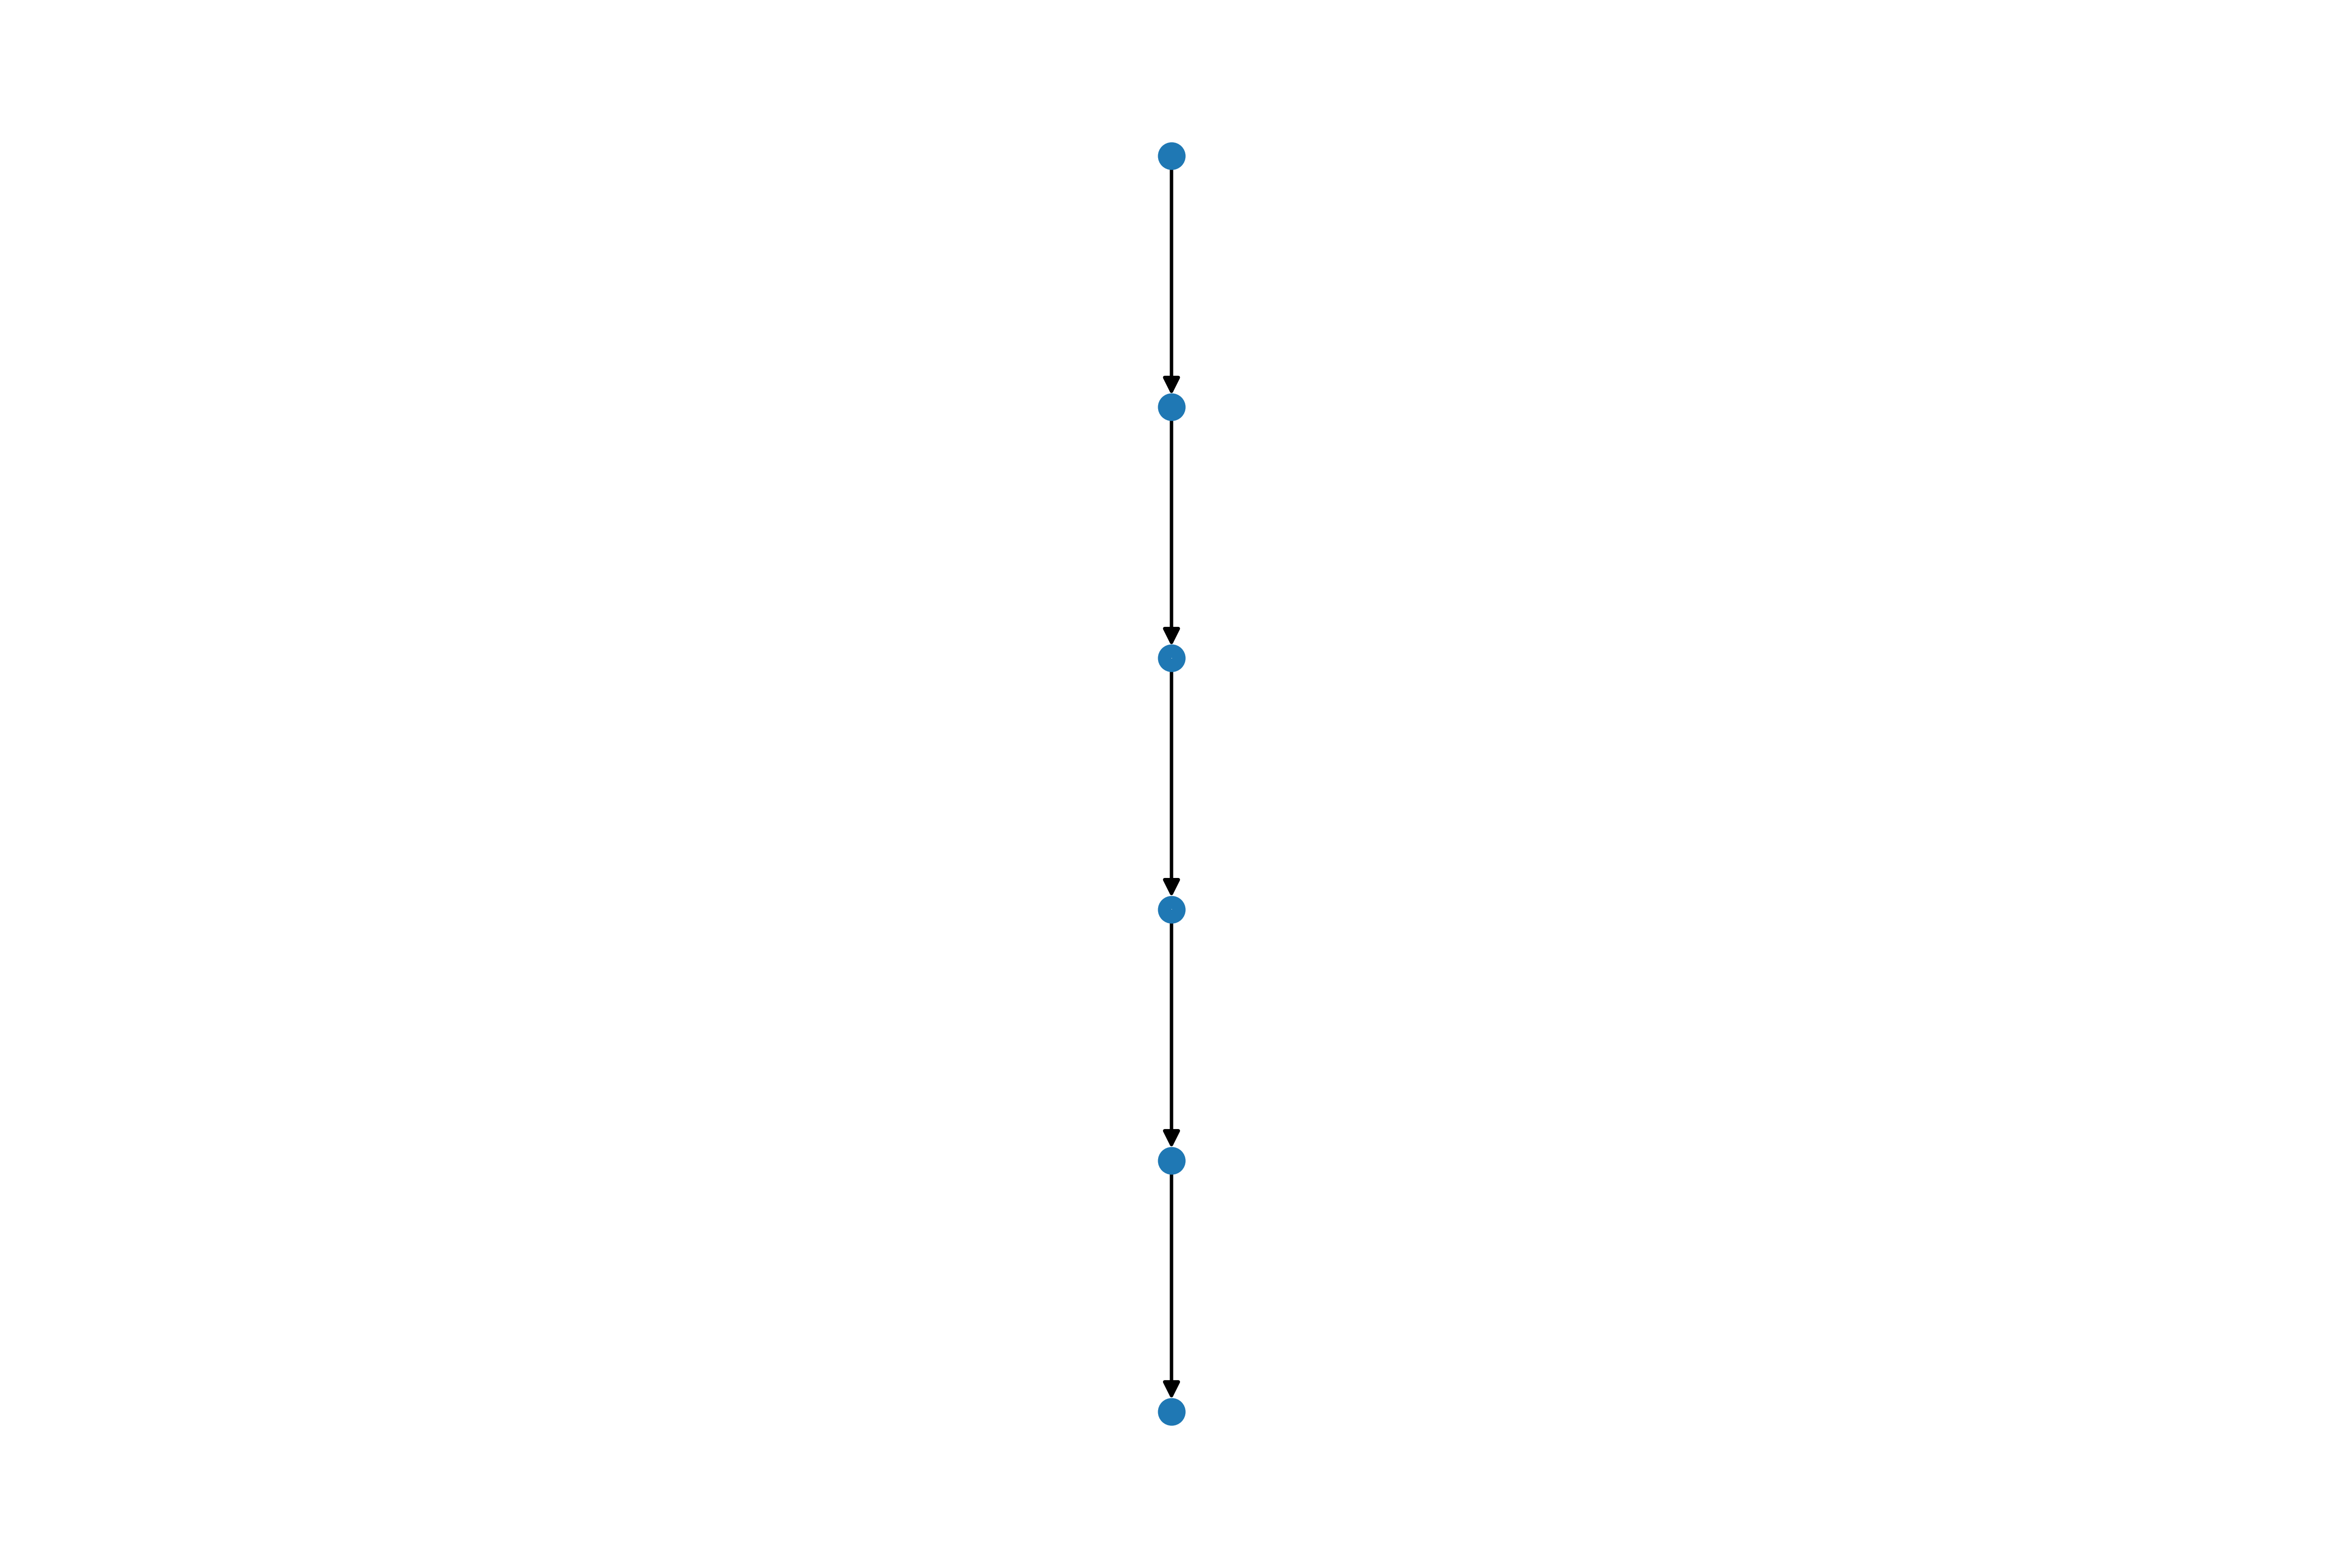

In [106]:
fig, G = generate_molecule_tree([drug_env.library[-1].inspiration])

In [48]:
import random

molecules = random.sample(drug_env.library[-100:-1].molecules, 10)

# Create a graph
G = nx.DiGraph()
for mol in molecules:
    G.add_node(mol)
    while mol.inspiration:
        G.add_edge(mol.inspiration, mol)
        mol = mol.inspiration
        G.add_node(mol)

In [77]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

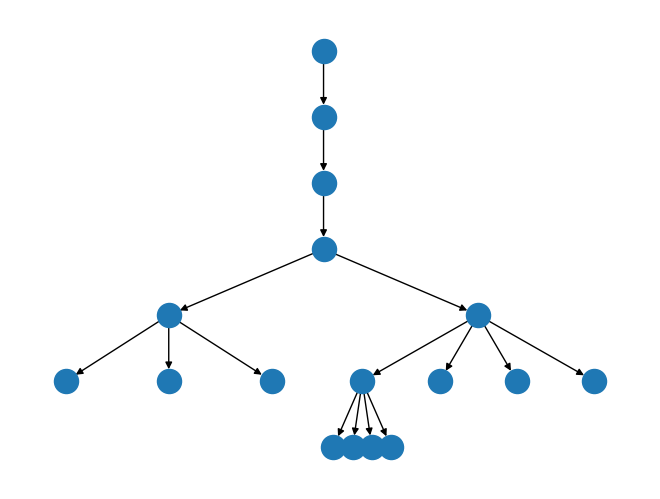

In [90]:
pos = hierarchy_pos(G, width = 3)

nx.draw(G, pos, arrows=True)